---
# Tutorial Task: Sentiment-Based Quant Strategy
---

In this tutorial, you will design and implement a **quantitative trading strategy** that makes trading decisions based on **news sentiment** for a selected group of 3 stocks.

## Objective

Each day, over a 1-week historical period:
- **Buy** (go long) the stock with the **most positive** news sentiment
- **Sell** (go short) the stock with the **most negative** news sentiment

You will:
1. Select your own **universe of 3 stocks** (e.g., AAPL, BRK-B, DNUT, MSFT, GOOGL, AMZN, TSLA).
2. Use the provided News API to retrieve articles for each stock.
3. Calculate the **average sentiment** for each stock daily using tools like `TextBlob`.
4. Track your portfolio’s value over time by simulating simple returns.
5. Plot your portfolio value and analyze strategy performance.

## Constraints

- The News API is limited to **100 requests per day**. Avoid excessive API calls while developing by storing data or limiting requests.
- You only trade **one long and one short position** per day.
- Keep it simple: assume equal capital allocation to long and short trades.


## Step 1:
Import relevant libraries

In [1]:
# Data analysis
import pandas as pd
import numpy as np

# API call
import requests

# Sentiment analysis
from textblob import TextBlob

# Time arithmetic
from datetime import datetime, timedelta

# Plotting
import matplotlib.pyplot as plt

# Financial data
import yfinance as yf


## Step 2:
Configure your API

https://newsapi.org/

In [2]:
# Information to call API
API_KEY = '49473ca1043f406faa5dd31934688163' # Replace with your actual key
BASE_URL = 'https://newsapi.org/v2/everything'

## Step 3:
Create a function to get news and calculate the sentiment

In [3]:
# We use TextBlob() to calculate sentiment:

# Show students how this works
print(TextBlob("This stock is amazing!").sentiment.polarity) # ~0.7-1 is a positive sentiment
print(TextBlob("This stock is okay").sentiment.polarity) # ~0.2 is a slightly positive sentiment
print(TextBlob("This stock is awful!").sentiment.polarity) # ~-0.8-1 is a negative sentiment
print(TextBlob("This is a stock").sentiment.polarity) # 0 is a neutral sentiment

0.7500000000000001
0.5
-1.0
0.0


In [4]:
# We make a function to call the API and get the sentiment of a stock over a day

def get_sentiment(stock, date):
    from_date = date.strftime('%Y-%m-%d')
    to_date = (date + timedelta(days = 1)).strftime('%Y-%m-%d')

    params = {
        'q': stock,
        'from': from_date,
        'to': to_date,
        'sortBy': 'relevancy',
        'apiKey': API_KEY,
        'language': 'en',
        'pageSize': 5
    }

    # Call API with the relevant stock and dates
    response = requests.get(BASE_URL, params=params)
    data = response.json() # response in a .JSON format

    print(data)

    sentiments = []
    for article in data.get('articles', []):
        title = article.get('title', '')
        description = article.get('description', '')

        if not title and not description:
            continue #skip if both are missing
               
        text = f"{title} {description}"
        # Get sentiment of text
        sentiment = TextBlob(text).sentiment.polarity
        sentiments.append(sentiment)

    if sentiments:
        mean = np.mean(sentiments)
        print(mean)
        return mean # return the mean sentiment of the stock over the day
    return None


In [5]:
get_sentiment('AAPL', datetime(2025, 5, 5))

{'status': 'ok', 'totalResults': 52, 'articles': [{'source': {'id': 'business-insider', 'name': 'Business Insider'}, 'author': 'wedwards@businessinsider.com (William Edwards)', 'title': 'BI Whale Watch: 9 stocks that investing legends like Warren Buffett are betting at least 20% of their portfolios on', 'description': "Warren Buffett is stepping down. Here's the one stock he's betting 28% of his portfolio on.", 'url': 'https://www.businessinsider.com/warren-buffett-stocks-top-investors-are-betting-on-whale-watch-2025-5', 'urlToImage': 'https://i.insider.com/6818f2683fe8d3928364f07e?width=921&format=jpeg', 'publishedAt': '2025-05-06T08:00:01Z', 'content': 'Warren Buffett, perhaps the greatest investor of all time, announced on Saturday that he would step down as CEO of Berkshire Hathaway at the end of the year.\r\nGiven the occasion, we thought it would … [+2779 chars]'}, {'source': {'id': None, 'name': '9to5Mac'}, 'author': 'Ben Lovejoy', 'title': 'Warren Buffett says Apple made Berksh

np.float64(0.1410674603174603)

## Step 4:
Simulate Trading by Backtesting

In [6]:
def gather_daily_sentiments(stocks, start_date, end_date):
    """
    For each date in [start_date, end_date], calls get_sentiment(stock, date)
    and returns a DataFrame of shape (n_dates * n_stocks) of daily polarity
    """

    dates = pd.date_range(start_date, end_date)
    # initialise and empy dataframe
    sentiments = pd.DataFrame(index=dates, columns=stocks, dtype=float)

    for date in dates:
        for stock in stocks:
            sentiments.at[date, stock] = get_sentiment(stock, date)
    return sentiments

def fetch_price_data(stocks, start_date, end_date):
    """
    Downloads daily OHLC data for each ticker in 'stocks' between start_date and end_date. Returns a dict mapping ticker to its dataframe
    """

    price_data = {}
    for stock in stocks:
        df = yf.download(
            stock,
            start = start_date.strftime('%Y-%m-%d'),
            end = (end_date + timedelta(days = 1)).strftime('%Y-%m-%d'),
            interval = '1d',
            progress = False
        )
        price_data[stock] = df[['Open', 'Close']] # keep only what is needed
    return price_data

In [7]:

# Define parameters for the API and its functions

START_DATE = pd.to_datetime('2025-04-28')
END_DATE = pd.to_datetime('2025-05-09')
STOCK_UNIVERSE = ['AAPL', 'DNUT', 'BRK-B']

#1) Get your sentiment surface

sentiment_df = gather_daily_sentiments(STOCK_UNIVERSE, START_DATE, END_DATE)

# 2) Pull in all your price data

price_dict = fetch_price_data(STOCK_UNIVERSE, START_DATE, END_DATE)

# Now you will have:
# - sentiment_df.loc[date, stock] which is polarity of the stock on that date
# - price_dict[stock].loc[date, ['Open', 'Close']] prices

{'status': 'ok', 'totalResults': 70, 'articles': [{'source': {'id': None, 'name': 'AppleInsider'}, 'author': 'news@appleinsider.com (Wesley Hilliard)', 'title': 'Consumers get ahead of tariffs, Morgan Stanley hikes AAPL price target to $235', 'description': "Morgan Stanley hiked its Apple stock price target to $235 because instability created by the Trump administration's tariffs may be a boon to Apple's bottom line — at least in the short term.iPhone 16 Pro Max could have seen a sale bump in early 2025Even after…", 'url': 'https://appleinsider.com/articles/25/04/28/consumers-get-ahead-of-tariffs-morgan-stanley-hikes-aapl-price-target-to-235', 'urlToImage': 'https://photos5.appleinsider.com/gallery/63435-131825-Cameras-16-Pro-Max-xl.jpg', 'publishedAt': '2025-04-28T20:47:49Z', 'content': "Morgan Stanley hiked its Apple stock price target to $235 because instability created by the Trump administration's tariffs may be a boon to Apple's bottom line — at least in the short term.\r\nEven a

In [8]:

# Daily sentiment per stock

sentiment_df

,AAPL,DNUT,BRK-B
2025-04-28,-0.005000,0.20,0.380952
2025-04-29,0.183333,NaN,0.523810
2025-04-30,0.002778,NaN,0.666667
2025-05-01,0.062778,NaN,0.211039
2025-05-02,0.108232,NaN,0.170000
2025-05-03,0.159820,NaN,0.153889
2025-05-04,0.128905,0.01,0.114352
2025-05-05,0.141067,0.01,0.051574
2025-05-06,0.300337,NaN,0.106111
2025-05-07,NaN,NaN,NaN


In [9]:
# Price data for each stock

print(price_dict['DNUT'])

Price       Open Close
Ticker      DNUT  DNUT
Date                  
2025-04-28  4.29  4.19
2025-04-29  4.15  4.14
2025-04-30  4.06  4.10
2025-05-01  4.12  4.22
2025-05-02  4.22  4.31
2025-05-05  4.30  4.27
2025-05-06  4.29  4.36
2025-05-07  4.40  4.33
2025-05-08  3.03  3.26
2025-05-09  3.27  2.73


In [10]:
# Import backtesting functionality from python file

from momentum_functions import backtest_sentiment_strategy

In [11]:
# Example usage

results = backtest_sentiment_strategy(sentiment_df, price_dict, init_capital=100000)
results


/workspaces/FM_momentum/Tutorial/momentum_functions.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/workspaces/FM_momentum/Tutorial/momentum_functions.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/workspaces/FM_momentum/Tutorial/momentum_functions.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close'])
/workspaces/FM_momentum/Tutorial/momentum_functions.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(row['Open']), float(row['Close

,long,short,open_long,close_long,open_short,close_short,pnl_long,pnl_short,daily_pnl,daily_return,portfolio_value
date,,,,,,,,,,,
2025-04-28,BRK-B,AAPL,533.630005,530.940002,210.000000,210.139999,-252.047525,-33.333188,-285.380713,-0.002854,99714.619287
2025-04-29,BRK-B,AAPL,531.000000,534.570007,208.690002,211.210007,335.199549,-602.044333,-266.844784,-0.002676,99447.774503
2025-04-30,BRK-B,AAPL,531.510010,533.250000,209.300003,212.500000,162.779772,-760.230698,-597.450926,-0.006008,98850.323577
2025-05-01,BRK-B,AAPL,531.000000,530.229980,209.080002,213.320007,-71.672957,-1002.309908,-1073.982865,-0.010865,97776.340712
2025-05-02,BRK-B,AAPL,536.750000,539.799988,206.089996,205.350006,277.798459,175.538693,453.337152,0.004636,98229.677864
2025-05-03,AAPL,BRK-B,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,98229.677864
2025-05-04,AAPL,DNUT,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,98229.677864
2025-05-05,AAPL,DNUT,203.100006,198.889999,4.300000,4.270000,-1018.088604,342.664048,-675.424556,-0.006876,97554.253308
2025-05-06,AAPL,BRK-B,198.210007,198.509995,509.570007,512.330017,73.823430,-264.194015,-190.370584,-0.001951,97363.882724


## Step 5:
Display results in ```matplotlib```

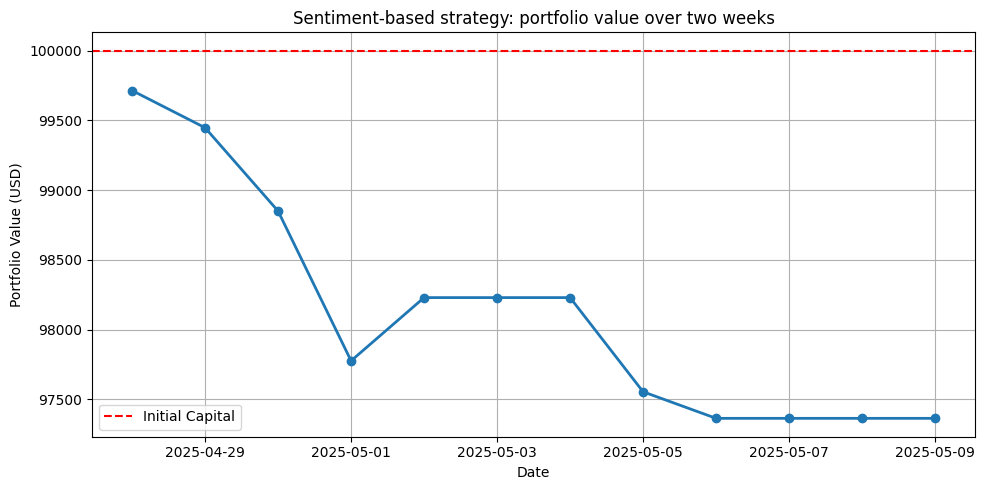

In [12]:

# Plot the portfolio value

plt.figure(figsize=(10, 5))
plt.plot(results.index, results['portfolio_value'], marker = 'o', linewidth = 2)
plt.title('Sentiment-based strategy: portfolio value over two weeks')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.axhline(y=100000, color='r', linestyle='--', label='Initial Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()